# **Desafio: Preveja os usuários com alta chance de deixar seu Streaming**


Utilize um modelo de classificação para mapear qual o perfil de usuários tem mais chance de deixar sua plataforma de streaming. Compreender quem é o perfil que está aumentando o churn do seu negócio é essencial para tomar ações que reduzam essas perdas, seja alterando critérios na venda ou modificando o produto.

## **Contexto**

Você trabalha em uma plataforma de streaming e a diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn. Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

### **Sobre os dados**

Os dados fornecidos possuem informações sobre as contas dos clientes na plataforma de streaming, divididos entre contas Basic, Standard e Premium, onde cada uma oferece uma gama maior de serviços que a anterior.

| Coluna | Descrição | Tipo |
| ----------- | ----------- | ----------- |
| *user_id* | Código de identificação do cliente | Int |
| *age* | Idade do cliente | Int |
| *gender* | Gênero do cliente | String |
| *time_on_platform* | Dias de assinatura ativa do cliente | Int |
| *subscription_type* | Tipo de conta | String |
| *avg_rating* | Avaliação média dos conteúdos da plataforma | Int |
| *num_active_profiles* | Número de perfis ativos na plataforma | Int|
|*num_streaming_services* |Quantidade de serviços de streaming que o cliente possui |Int|
|*devices_connected*| Quantidade de dispositivos conectados à conta| Int|
|*churned* |Se o cliente cancelou a conta ou não| Int|

## **EDA**

### Bibliotecas

In [605]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Data Understanding

In [606]:
# Criação do dataframe
df = pd.read_csv("streaming_data.csv")
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [607]:
# Descrição estatística dos dados
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [608]:
# Verificação dos tipos de dados e valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [609]:
# Verificação de valores faltantes por coluna
df.isna().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [610]:
# Verificação de linhas duplicadas
df.duplicated().sum()

12403

#### Análise Univariada

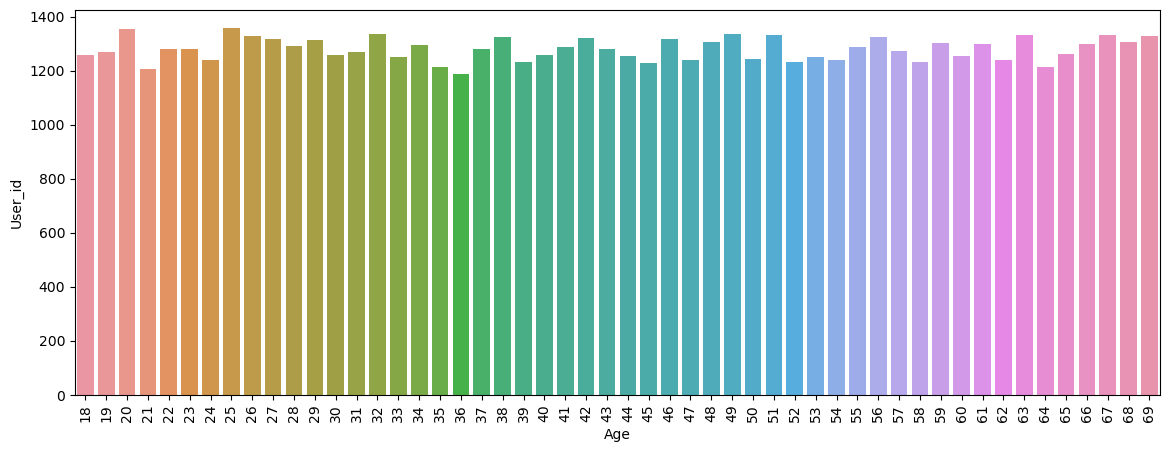

In [611]:
# Age
agg_age = df.groupby("Age")['User_id'].count().reset_index()
agg_age = agg_age.astype({"Age":'int'})

plt.figure(figsize=(14,5))
plot = sns.barplot(data=agg_age, x ="Age", y ="User_id")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

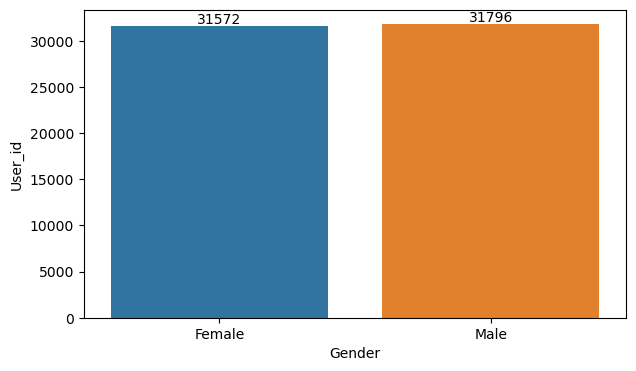

In [612]:
# Gender
agg_gender = df.groupby("Gender")['User_id'].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=agg_gender, x="Gender", y="User_id")
ax.bar_label(ax.containers[0]);

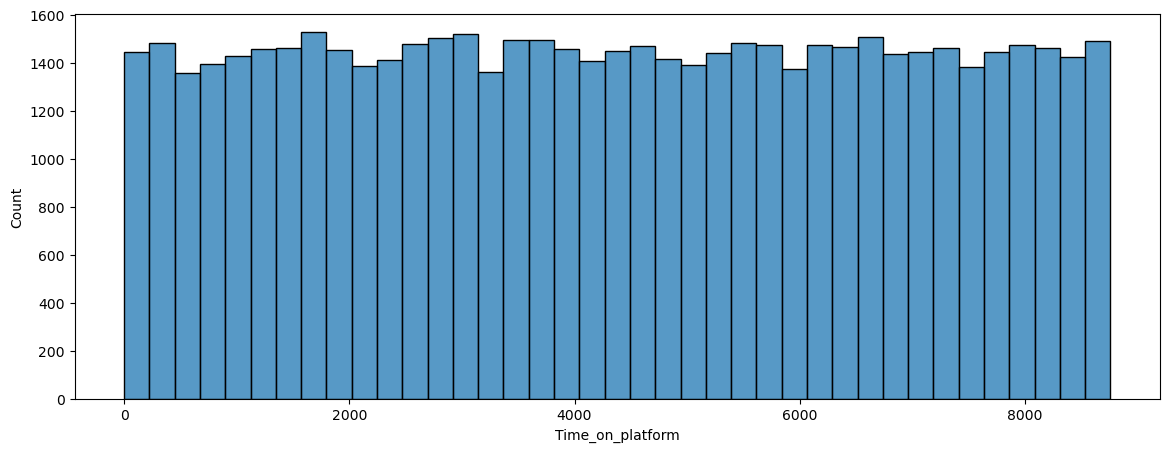

In [613]:
# Time_on_platform
agg_top = df["Time_on_platform"]

plt.figure(figsize=(14,5))
sns.histplot(data=agg_top);

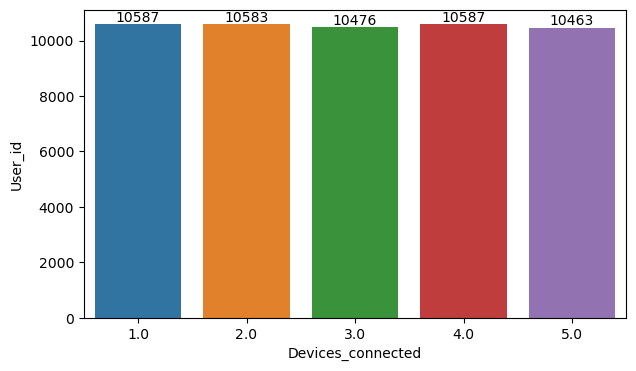

In [614]:
# Devices_connected
agg_dc = df.groupby("Devices_connected")["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=agg_dc, x="Devices_connected", y="User_id")
ax.bar_label(ax.containers[0]);

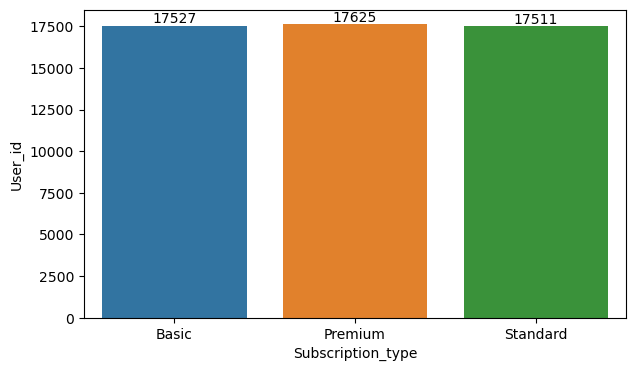

In [615]:
# Subscription_type
agg_st = df.groupby("Subscription_type")["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=agg_st, x="Subscription_type", y="User_id")
ax.bar_label(ax.containers[0]);

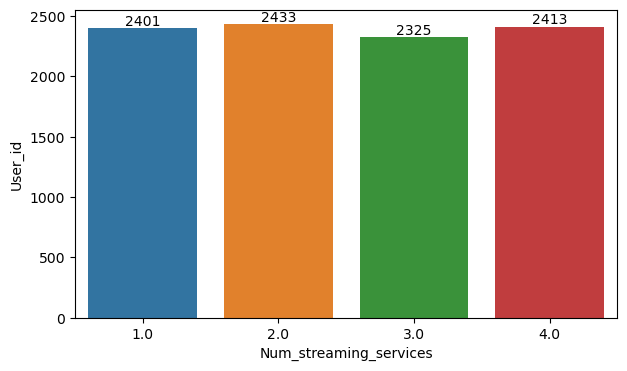

In [616]:
# Num_streaming_services
agg_nss = df.groupby("Num_streaming_services")["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=agg_nss, x="Num_streaming_services", y="User_id")
ax.bar_label(ax.containers[0]);

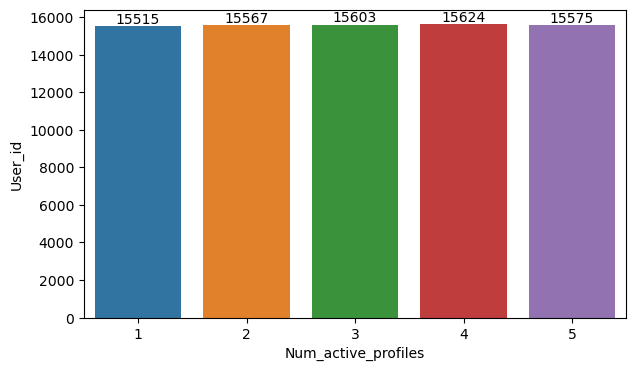

In [617]:
# Num_active_profiles
agg_nap = df.groupby("Num_active_profiles")["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=agg_nap, x="Num_active_profiles", y="User_id")
ax.bar_label(ax.containers[0]);

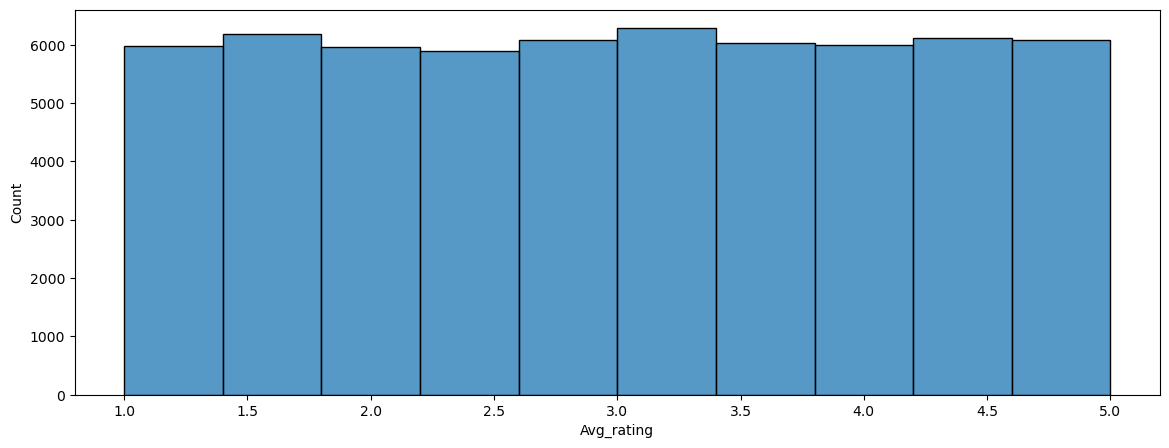

In [618]:
# Avg_rating
agg_ar = df["Avg_rating"]

plt.figure(figsize=(14,5))
sns.histplot(data=agg_ar, bins=10);

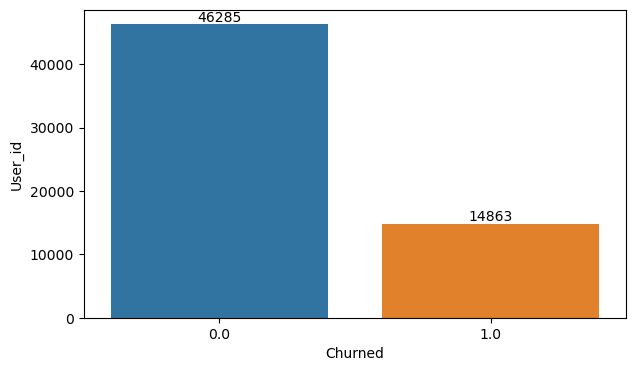

In [619]:
# Churned
agg_churn = df.groupby("Churned")["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=agg_churn, x="Churned", y="User_id")
ax.bar_label(ax.containers[0]);

#### Análise Multivariada

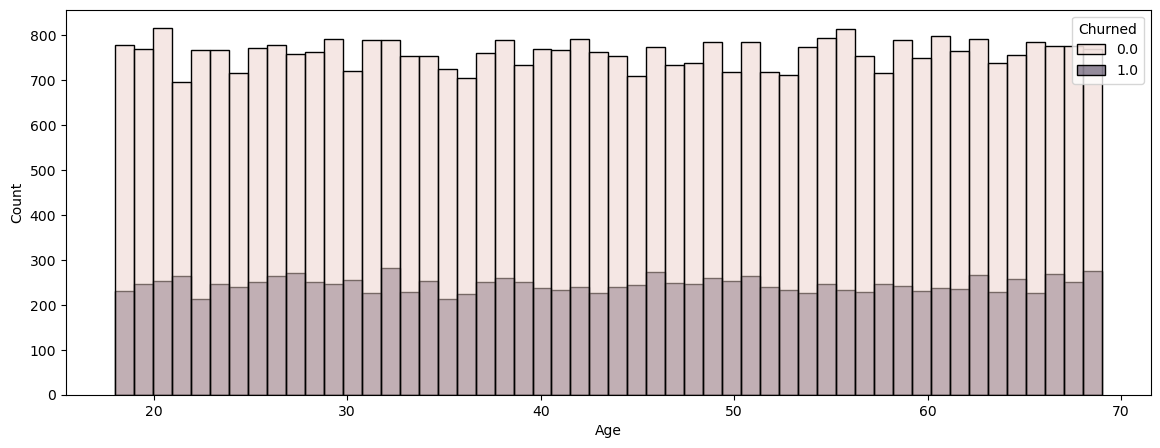

In [620]:
# Churn x Age
churn_age = df[["Age", "Churned"]]

plt.figure(figsize=(14,5))
sns.histplot(data=churn_age, x="Age", hue="Churned", bins=52);

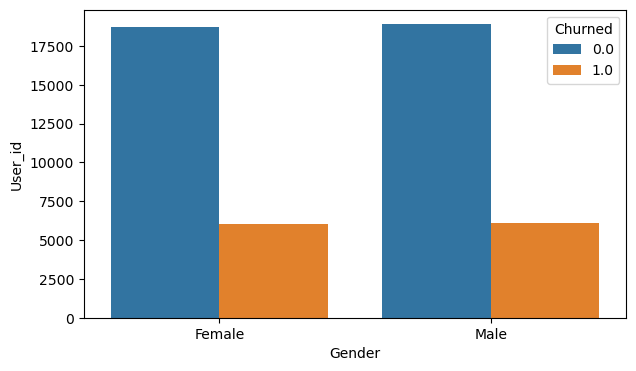

In [621]:
# Churn x Gender
churn_gender = df.groupby(["Gender","Churned"])['User_id'].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=churn_gender, x="Gender", y="User_id", hue="Churned")

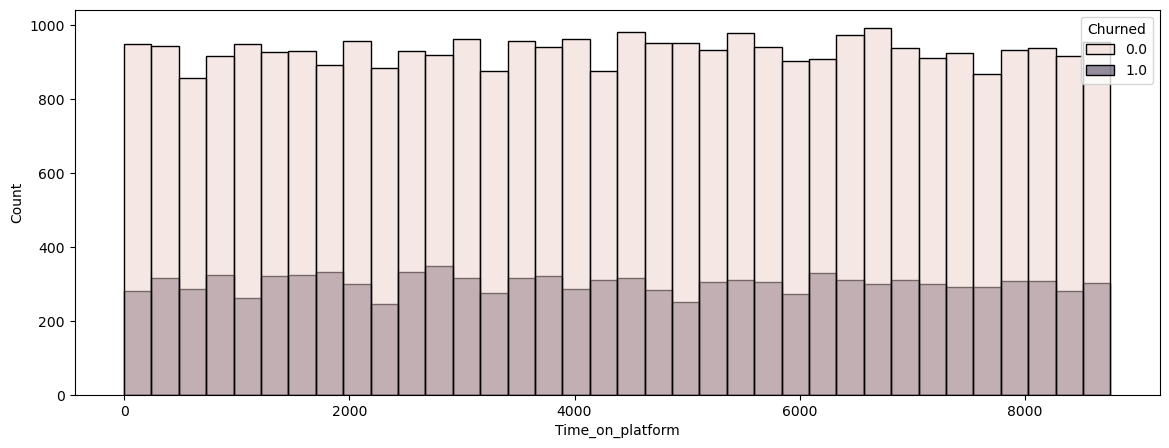

In [622]:
# Churn x Time_on_platform
churn_top = df[["Time_on_platform", "Churned"]]

plt.figure(figsize=(14,5))
sns.histplot(data=churn_top, x="Time_on_platform", hue="Churned");

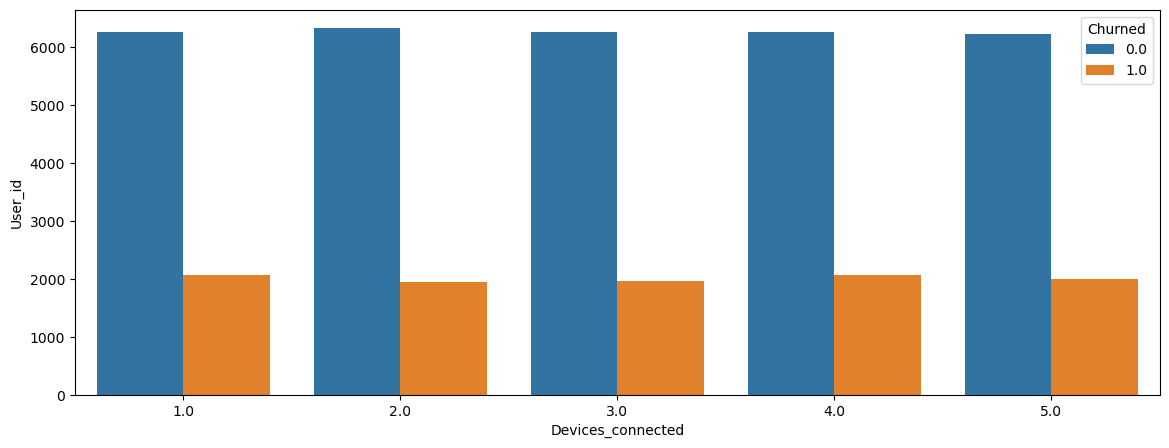

In [623]:
# Churn x Devices_connected
churn_dc = df.groupby(["Devices_connected","Churned"])["User_id"].count().reset_index()

plt.figure(figsize=(14,5))
ax = sns.barplot(data=churn_dc, x="Devices_connected", y="User_id", hue="Churned")

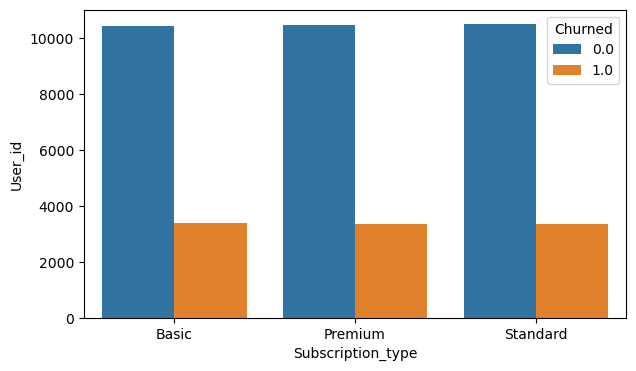

In [624]:
# Churn x Subscription_type
churn_st = df.groupby(["Subscription_type","Churned"])["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=churn_st, x="Subscription_type", y="User_id", hue="Churned")

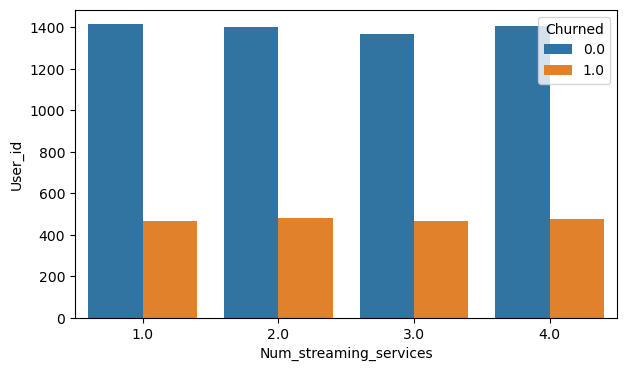

In [625]:
# Churn x Num_streaming_services
churn_nss = df.groupby(["Num_streaming_services","Churned"])["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=churn_nss, x="Num_streaming_services", y="User_id", hue="Churned")


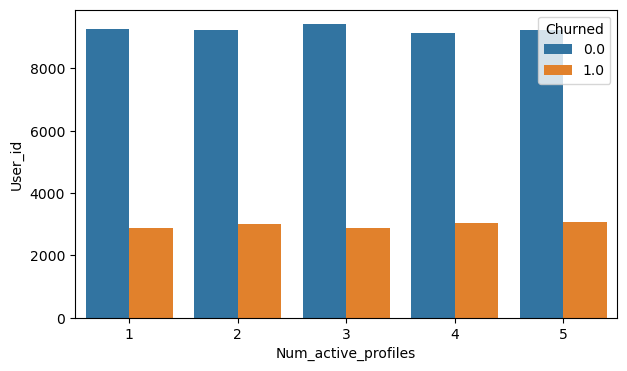

In [626]:
# Churn x Num_active_profiles
churn_nap = df.groupby(["Num_active_profiles","Churned"])["User_id"].count().reset_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(data=churn_nap, x="Num_active_profiles", y="User_id", hue="Churned")

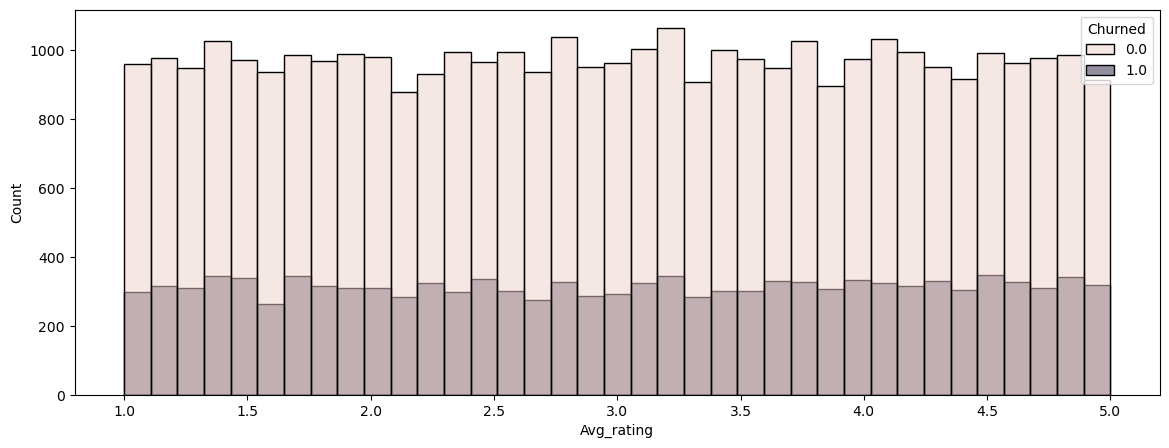

In [627]:
# Churn x Avg_rating
churn_ar = df[["Avg_rating","Churned"]]

plt.figure(figsize=(14,5))
sns.histplot(data=churn_ar, x="Avg_rating",hue="Churned");

### Data Preparation

In [628]:
# Remoção de linhas duplicadas
df = df.drop_duplicates()
df.duplicated().sum()

0

In [629]:
# Drop de linhas nulas nas colunas Gender, Subscription_type e Age
df = df.dropna(subset=["Gender", "Subscription_type", "Age"])
df.isna().sum()

Age                           0
Gender                        0
Time_on_platform           8469
Devices_connected          9855
Subscription_type             0
Num_streaming_services    26886
Num_active_profiles           0
Avg_rating                 6813
Churned                    6567
User_id                       0
dtype: int64

In [630]:
# Substituição de valores NaN
df = df.fillna(0)
df.isna().sum()

Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
Churned                   0
User_id                   0
dtype: int64

In [631]:
# Transformação de valores Churned
df = df.replace({"Churned":{0:"No", 1:"Yes"}})
df.Churned.value_counts()

Churned
No     24774
Yes     5965
Name: count, dtype: int64

In [632]:
# Transformação dos tipos de variáveis
df = df.astype({"Age": int,
                "Time_on_platform": int,
                "Devices_connected": int,
                "Num_streaming_services": int,
                "Num_active_profiles": int,
                "Avg_rating": int})

df.dtypes

Age                        int32
Gender                    object
Time_on_platform           int32
Devices_connected          int32
Subscription_type         object
Num_streaming_services     int32
Num_active_profiles        int32
Avg_rating                 int32
Churned                   object
User_id                   object
dtype: object

### Modelagem dos Dados

In [633]:
# Criação das features e target
X = df.drop(columns=["User_id", "Churned"], axis=1)
y = df[["Churned"]]

In [634]:
# Label Encoder
le = LabelEncoder()

y.Churned = le.fit_transform(y.Churned)

C:\Users\vinic\AppData\Local\Temp\ipykernel_8048\392571996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.Churned = le.fit_transform(y.Churned)


In [635]:
# Get_dummies
X = pd.get_dummies(X, dtype=int)

In [636]:
# Criação da base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_train: (24591, 11)
Shape y_train: (24591, 1)
Shape X_test: (6148, 11)
Shape y_test: (6148, 1)


In [637]:
# Scaler
scaler = MinMaxScaler()

X_train[:] = scaler.fit_transform(X_train)
X_test[:] = scaler.transform(X_test)

#### Regressão Logística

In [638]:
# Criação e treinamento do modelo
modelLR = LogisticRegression(class_weight="balanced")
lr = modelLR.fit(X_train, y_train.values.ravel())

In [639]:
# Previsão do modelo
y_pred = pd.DataFrame(lr.predict(X_test))

In [640]:
# Visualição do valores reais e preditos
X_test.assign(Real = y_test).assign(Predict = lr.predict(X_test))

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,Real,Predict
39945,1.000000,0.410777,0.0,0.0,0.50,0.4,0,1,1,0,0,0,1
29183,0.862745,0.005366,0.8,0.0,0.75,0.6,1,0,1,0,0,0,1
48127,0.941176,0.371275,0.2,0.5,0.50,0.6,1,0,0,0,1,0,1
46073,0.705882,0.914374,0.4,0.0,0.25,0.0,0,1,0,1,0,0,0
9298,0.666667,0.987441,1.0,0.0,0.00,0.2,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25381,0.686275,0.783994,0.0,0.0,0.75,0.0,0,1,1,0,0,0,0
52999,0.764706,0.118278,1.0,0.0,0.75,0.0,1,0,0,1,0,0,0
3822,0.196078,0.009019,0.8,0.0,0.50,0.0,1,0,1,0,0,0,0
49278,0.725490,0.000000,0.6,0.0,0.00,0.2,1,0,0,0,1,0,0


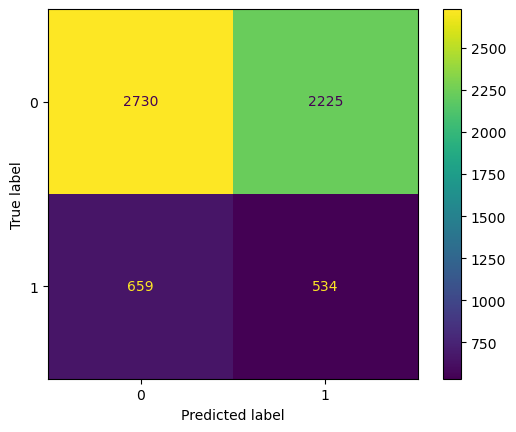

In [641]:
# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [642]:
# Métricas
print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.5268187548290025
Acurácia (Teste): 0.5309043591411842
Acurácia Balanceada (Treino): 0.5062966324702091
Acurácia Balanceada (Teste): 0.499284846096004
Precision (Treino): 0.19831223628691982
Precision (Teste): 0.1935483870967742
Recall (Treino): 0.4727577535624476
Recall (Teste): 0.44761106454316846
F1-Score (Treino): 0.27941540748080257
F1-Score (Teste): 0.2702429149797571
ROCAUC (Treino): 0.5103547118184024
ROCAUC (Teste): 0.4990040287144231


#### Random Forest

In [643]:
# Criação e treinamento do modelo
modelRF = RandomForestClassifier(class_weight="balanced")
rf = modelRF.fit(X_train, y_train.values.ravel())

In [644]:
# Previsão do modelo
y_pred = pd.DataFrame(rf.predict(X_test))

In [645]:
# Visualição do valores reais e preditos
X_test.assign(Real = y_test).assign(Predict = rf.predict(X_test))

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,Real,Predict
39945,1.000000,0.410777,0.0,0.0,0.50,0.4,0,1,1,0,0,0,0
29183,0.862745,0.005366,0.8,0.0,0.75,0.6,1,0,1,0,0,0,0
48127,0.941176,0.371275,0.2,0.5,0.50,0.6,1,0,0,0,1,0,0
46073,0.705882,0.914374,0.4,0.0,0.25,0.0,0,1,0,1,0,0,0
9298,0.666667,0.987441,1.0,0.0,0.00,0.2,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25381,0.686275,0.783994,0.0,0.0,0.75,0.0,0,1,1,0,0,0,0
52999,0.764706,0.118278,1.0,0.0,0.75,0.0,1,0,0,1,0,0,0
3822,0.196078,0.009019,0.8,0.0,0.50,0.0,1,0,1,0,0,0,0
49278,0.725490,0.000000,0.6,0.0,0.00,0.2,1,0,0,0,1,0,0


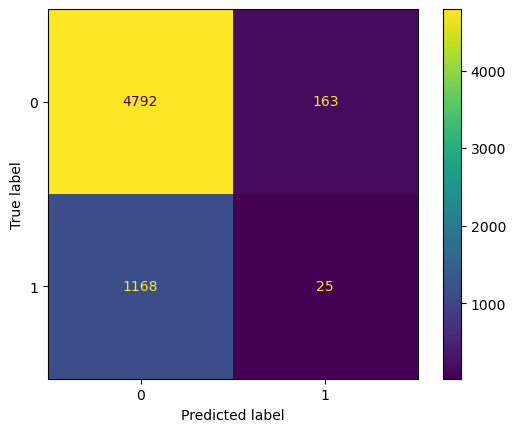

In [646]:
# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [647]:
# Métricas
print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.9941035338131837
Acurácia (Teste): 0.7835068314899154


Acurácia Balanceada (Treino): 0.9954668490408185
Acurácia Balanceada (Teste): 0.4940297548007508
Precision (Treino): 0.9726251276813075
Precision (Teste): 0.13297872340425532
Recall (Treino): 0.9976948868398994
Recall (Teste): 0.020955574182732608
F1-Score (Treino): 0.9850005172235439
F1-Score (Teste): 0.036205648081100654
ROCAUC (Treino): 0.9995380342138263
ROCAUC (Teste): 0.4789333676178651


#### Tunning

In [648]:
# Parâmetros do GridSearchCV
parameters = {'max_depth': [1,2,3],
              'n_estimators': [100, 200, 300, 400, 500]}

grid_search = GridSearchCV(rf, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [649]:
# Busca pelos melhores parâmetros
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [650]:
# Obtenção dos melhores parâmetros
grid_search.best_estimator_.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [651]:
# Criação e treinamento do modelo tunado
rf_tunned =  RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0,
                                     class_weight = 'balanced', criterion= 'gini',
                                     max_depth = 3, max_features= 'sqrt',
                                     max_leaf_nodes = None,
                                     max_samples = None,
                                     min_impurity_decrease = 0.0,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     min_weight_fraction_leaf = 0.0,
                                     n_estimators = 500, n_jobs = None,
                                     oob_score = False, random_state = None,
                                     verbose = 0, warm_start = False)

rf_tunned.fit(X_train, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=500)

In [652]:
# Previsão do modelo tunado
y_pred = pd.DataFrame(rf_tunned.predict(X_test))

In [653]:
# Visualização dos valores reais e preditos
X_test.assign(Real = y_test).assign(Predict = rf_tunned.predict(X_test))

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,Real,Predict
39945,1.000000,0.410777,0.0,0.0,0.50,0.4,0,1,1,0,0,0,1
29183,0.862745,0.005366,0.8,0.0,0.75,0.6,1,0,1,0,0,0,1
48127,0.941176,0.371275,0.2,0.5,0.50,0.6,1,0,0,0,1,0,0
46073,0.705882,0.914374,0.4,0.0,0.25,0.0,0,1,0,1,0,0,0
9298,0.666667,0.987441,1.0,0.0,0.00,0.2,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25381,0.686275,0.783994,0.0,0.0,0.75,0.0,0,1,1,0,0,0,1
52999,0.764706,0.118278,1.0,0.0,0.75,0.0,1,0,0,1,0,0,0
3822,0.196078,0.009019,0.8,0.0,0.50,0.0,1,0,1,0,0,0,0
49278,0.725490,0.000000,0.6,0.0,0.00,0.2,1,0,0,0,1,0,0


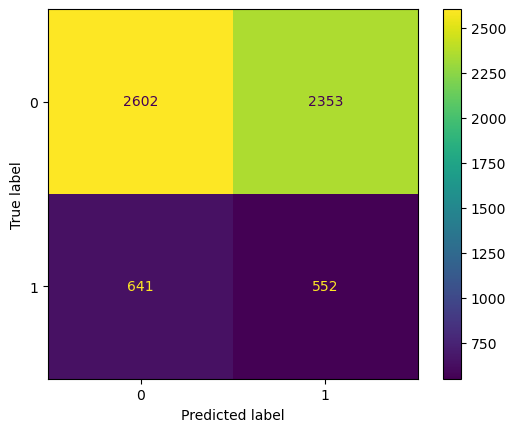

In [654]:
# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [655]:
# Métricas
print(f"Acurácia (Treino): {accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf_tunned.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf_tunned.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf_tunned.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf_tunned.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf_tunned.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.5367817494205197
Acurácia (Teste): 0.5130123617436565


Acurácia Balanceada (Treino): 0.5318081117347535
Acurácia Balanceada (Teste): 0.4939126065858443
Precision (Treino): 0.2151157786003271
Precision (Teste): 0.1900172117039587
Recall (Treino): 0.5236797988264879
Recall (Teste): 0.46269907795473597
F1-Score (Treino): 0.30496064433461473
F1-Score (Teste): 0.26939970717423134
ROCAUC (Treino): 0.5528707000787978
ROCAUC (Teste): 0.4860986091927092


Observamos que o tunning dos hiperparâmetros diminuiu a acurácia do modelo de maneira geral, porém aumentou outras métricas como precisão, recall e f1-score. Além disto, observamos que o overfitting que havia antes foi reduzido de maneira considerável, visto que a performance do modelo no treino e no teste ficou mais próxima após a otimização.